# EEGMapping: Group Analysis (Local Data)

Words, words, words.

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import pickle

import mne
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import ttest_1samp, ttest_ind, sem, pearsonr

from fooof import FOOOF, FOOOFGroup

In [25]:
# Import custom code for this analysis
% autoreload 2
from plots import *
from utilities import *
from analysis import *

## Settings

Put all general settings here. 

In [14]:
# Set whether to save out all the figures
SAVE_FIGS = False

# Whether to make the data
MASKING = True

# This controls how much stuff MNE prints out
mne.set_log_level(verbose=False)

# To Do's - master version:

### Plotting
- Figure out how to plot topographies with nan values
    - Use MNE masks to select which channels will be plotted
        - Suggestion: add a check for which channels have data. Boolean select these channels & positions to pass into plotting.
- Reorganize notebook for which parts you have to re run

### Quantitative Corrs
- Set it up to measure correlation & plot scatterplot
    - Generally, for any band, any FOOOF feature 
        - First: set band & feature, run to see results (finish the generalization: get a scatter plot & corr)
        - Also: add to plot Medial -> Lateral (abs)
- Collect all R's into corr matrix
- Bonus: plot the corr matrix as a colored plot (red/blue). Hint: plt.imshow(matrix). Extra bonus: add a colorbar. 
        
### Per subject analysis
- Do the same spatial correlations, per subject, collect distributions of r-vals & p-vals
- Plot: boxplots of the R-values, across subjects

### Band to Band Correlations
- Amplitude-amplitude correlations between bands (across channels)
- Plot: corr-matrix

# Loading information

In [15]:
#lOADING CHANNELS FROM txt
#save_path = "C:\\Users\\abc\\EEG-MNE\\data"
save_path = '../data'

chan_dat = 'channel_dat.txt'
chan_file = os.path.join(save_path, chan_dat)

In [16]:
# Set up subject numbers
subj_dat_num = list(range(3502, 3516))
subj_dat_num2 =list(range(3001, 3015))
all_subj = subj_dat_num + subj_dat_num2

In [17]:
# #LOADING CHANNELS from raw data
# # This base path will need updating
# base_path = 'D:\\abc\\Documents\\Research\\PBA_Data'

# # These should stay the same
# #subj_dat_fname = '._3001_resampled.set'
# subj_dat_fname = '3002_resampled.set'
# full_path = os.path.join(base_path, subj_dat_fname)
# eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)

# For Tom's Computer
save_path = '/Users/tom/Documents/Research/1-Projects/Phase/Experiments/PBA/2-Data/PBA-3/2-processed/EEG'
eeg_dat = mne.io.read_raw_eeglab(os.path.join(save_path, '3002_resampled.set'), preload=True, verbose=False)

Events like the following will be dropped entirely: ['Flash_instr', 'Catch_thresh', 'Catch_exp', 'Catch_instr', 'RETURN released'], 26 in total
5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.


<ipython-input-17-03cb41db4f7a>:13: RuntimeWarning: Events like the following will be dropped entirely: ['Flash_instr', 'Catch_thresh', 'Catch_exp', 'Catch_instr', 'RETURN released'], 26 in total
  eeg_dat = mne.io.read_raw_eeglab(os.path.join(save_path, '3002_resampled.set'), preload=True, verbose=False)
<ipython-input-17-03cb41db4f7a>:13: RuntimeWarning: 5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(os.path.join(save_path, '3002_resampled.set'), preload=True, verbose=False)


In [18]:
# Load and set the montage for the data
montage = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(montage)

<RawEEGLAB  |  3002_resampled.fdt, n_channels x n_times : 65 x 1896482 (3793.0 sec), ~940.6 MB, data loaded>

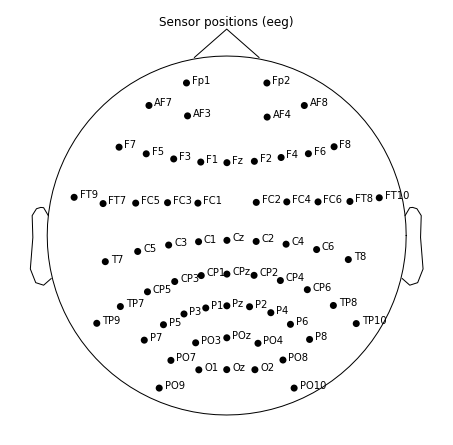

In [7]:
# Check the sensor map
eeg_dat.plot_sensors(show_names=True);

In [8]:
# Extract channel positions from a subjects data object
pos_new = np.asarray([ch['loc'][:3] for ch in eeg_dat.info['chs']])

# Drop stim channel
pos_new = pos_new[:-1, :]

In [9]:
# Update montage with channel positions
montage.pos = pos_new
pos = montage.get_pos2d()
montage = None

# DATA SET UP

In [10]:
# Load oscillations data
rtPB_rest_results = load_pickle('rtPB_rest_results')
rtPB_trial_results = load_pickle('rtPB_trial_results')
PBA_rest_results = load_pickle('PBA_rest_results')
PBA_trial_results = load_pickle('PBA_trial_results')

In [11]:
# Load slope data
rtPB_rest_slope_results = load_pickle('rtPB_rest_slope_results')
rtPB_trial_slope_results = load_pickle('rtPB_trial_slope_results')
PBA_rest_slope_results = load_pickle('PBA_rest_slope_results')
PBA_trial_slope_results = load_pickle('PBA_trial_slope_results')

In [ ]:
# # NEW Data
# ret = open('..\\data\\analysis\\rtPB_rest_results.pkl','rb')
# rtPB_rest_results = pickle.load(ret)

# ret = open('..\\data\\analysis\\rtPB_trial_results.pkl','rb')
# rtPB_trial_results = pickle.load(ret)

# ret = open('..\\data\\analysis\\PBA_rest_results.pkl','rb')
# PBA_rest_results = pickle.load(ret)

# ret = open('..\\data\\analysis\\PBA_trial_results.pkl','rb')
# PBA_trial_results = pickle.load(ret)

In [ ]:
# # Slope Data
# slope_ret = open('..\\data\\analysis\\rtPB_rest_slope_results.pkl','rb')
# rtPB_rest_slope_results = pickle.load(slope_ret)

# slope_ret = open('..\\data\\analysis\\rtPB_trial_slope_results.pkl','rb')
# rtPB_trial_slope_results = pickle.load(slope_ret)

# slope_ret = open('..\\data\\analysis\\PBA_rest_slope_results.pkl','rb')
# PBA_rest_slope_results = pickle.load(slope_ret)

# slope_ret = open('..\\data\\analysis\\PBA_trial_slope_results.pkl','rb')
# PBA_trial_slope_results = pickle.load(slope_ret)

## Masking

In [ ]:
# Set the channel cluster of interest    
pos_ch_cluster = ['Oz','O1','O2','POz','PO3','PO4','PO7','PO8','PO9','PO10']
# Check the indices for the channel cluster
pos_ch_cluster_index = masking_cluster(pos_ch_cluster, eeg_dat)

# Analyses across STATE

In [ ]:
# Set up date for state plots
rtpb_all_osc_data = [rtPB_trial_results, rtPB_rest_results]
pba_all_osc_data = [PBA_trial_results, PBA_rest_results]
comb_all_osc_data = [combine_groups_dict(rtPB_trial_results, PBA_trial_results),
                     combine_groups_dict(rtPB_rest_results, PBA_rest_results)]

# Make list of possible groups to run
groups_oscs = [rtpb_all_osc_data, pba_all_osc_data, comb_all_osc_data]

rtpb_all_slope_data = [rtPB_trial_slope_results, rtPB_rest_slope_results]
pba_all_slope_data = [PBA_trial_slope_results, PBA_rest_slope_results]
comb_all_slope_data = [combine_groups_array(rtPB_trial_slope_results, PBA_trial_slope_results),
                       combine_groups_array(rtPB_rest_slope_results, PBA_rest_slope_results)]

# Make list of possible groups to run
groups_slopes = [rtpb_all_slope_data, pba_all_slope_data, comb_all_slope_data]

# Set labels for group lists
labels = ['rtpb', 'pba', 'comb']

In [ ]:
# Run analysis across state - oscs
for label, group in zip(labels, groups_oscs):
    run_state_dict(group, label, False, SAVE_FIGS)

In [ ]:
# Run analysis across state - slope
for label, group in zip(labels, groups_slopes):
    run_state_array(group, label, False, ['Offset', 'Slope'], SAVE_FIGS)

# Analyses Across SPACE

CURRENT FEATURE: CFS


/Users/tom/Documents/GitCode/EEGMapping/local/notebooks/utilities.py:54: RuntimeWarning: Mean of empty slice
  bloc_aver_set = np.nanmean(feat_set, axis = 1)


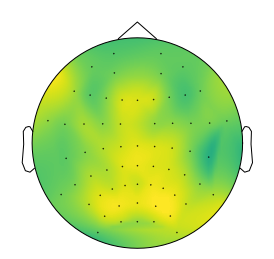

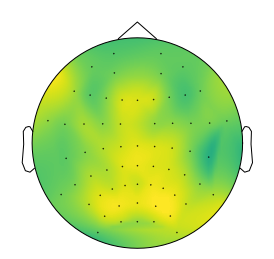

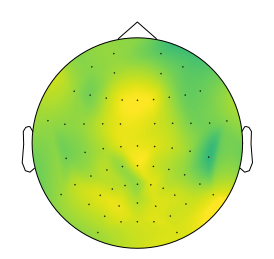

CURRENT FEATURE: CFS


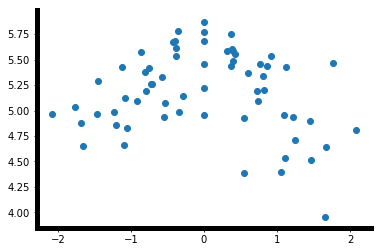

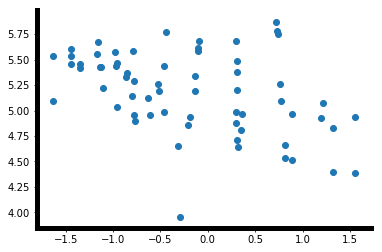

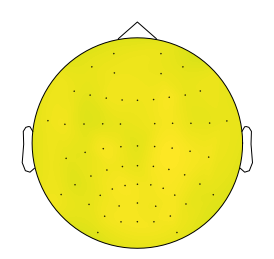

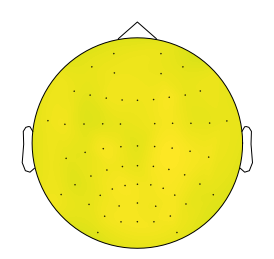

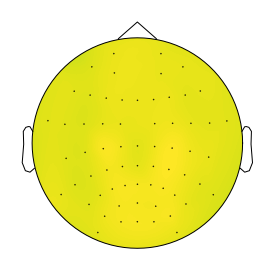

CURRENT FEATURE: CFS


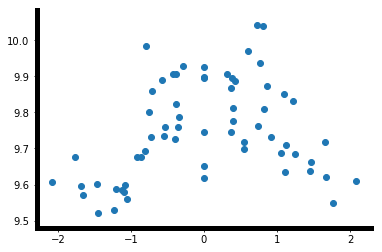

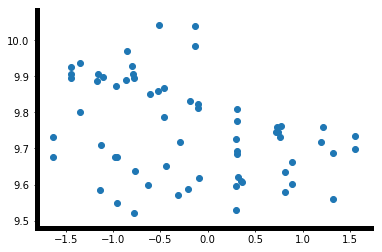

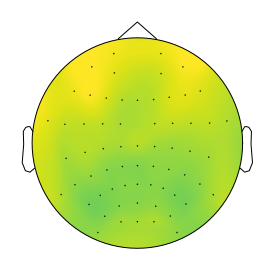

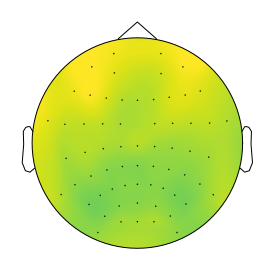

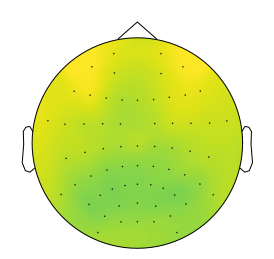

CURRENT FEATURE: CFS


/Users/tom/Documents/GitCode/EEGMapping/local/notebooks/utilities.py:55: RuntimeWarning: Mean of empty slice
  bloc_aver_set = np.nanmean(bloc_aver_set, axis = 0)


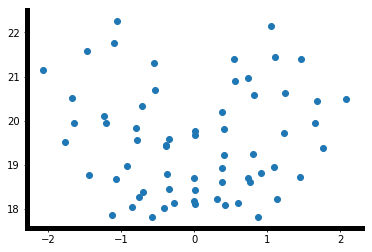

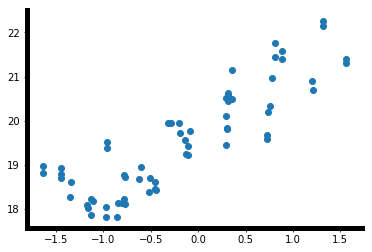

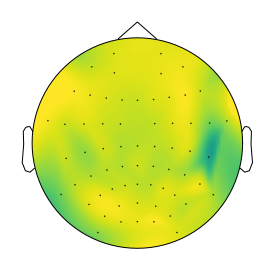

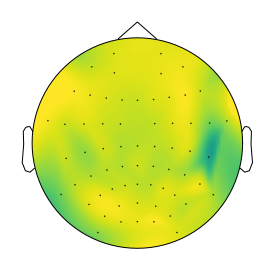

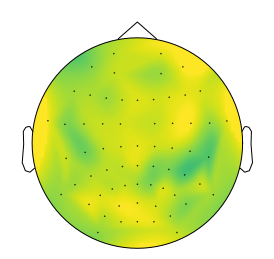

CURRENT FEATURE: CFS


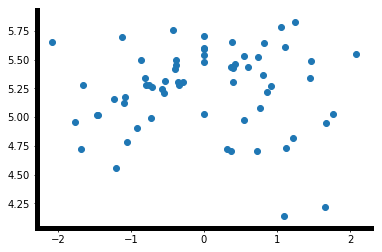

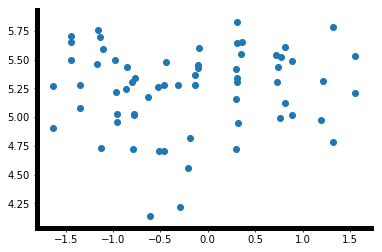

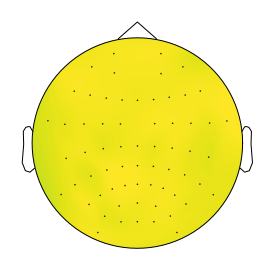

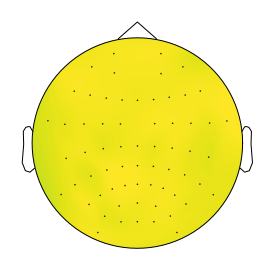

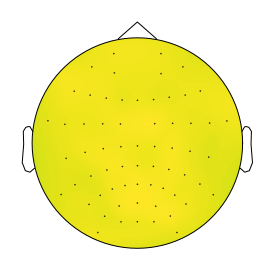

CURRENT FEATURE: CFS


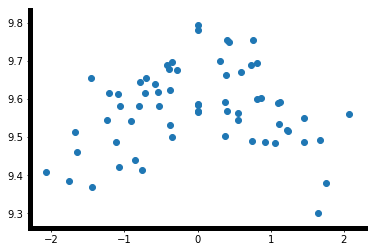

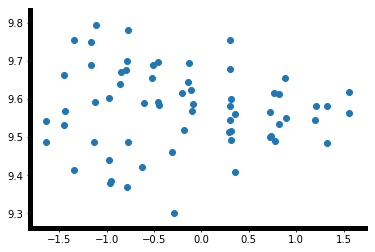

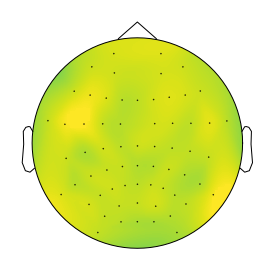

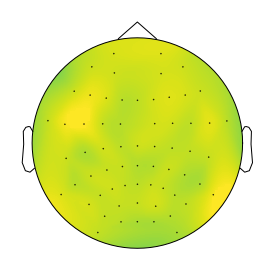

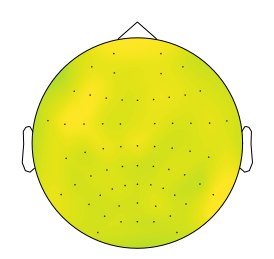

CURRENT FEATURE: Offsets


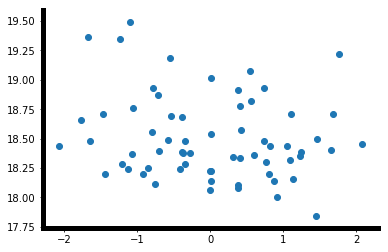

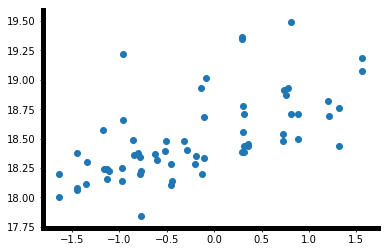

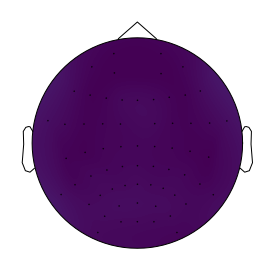

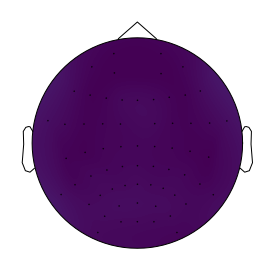

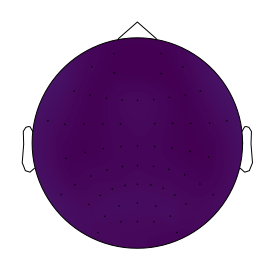

CURRENT FEATURE: Offsets


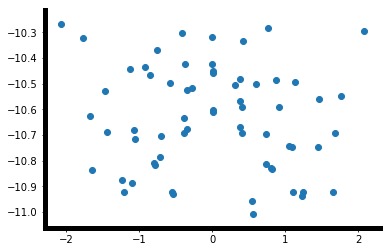

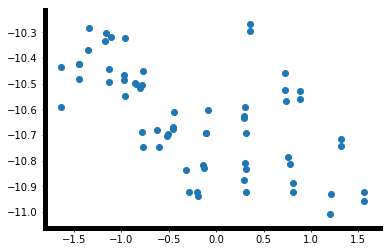

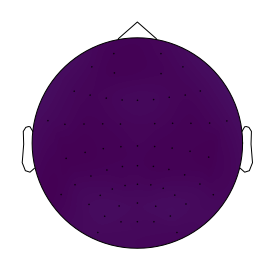

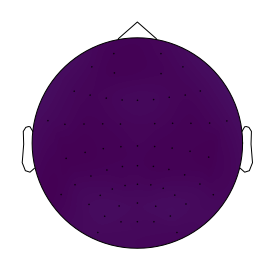

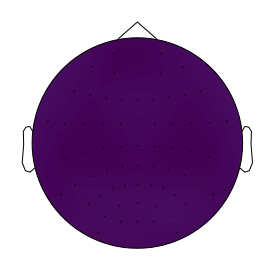

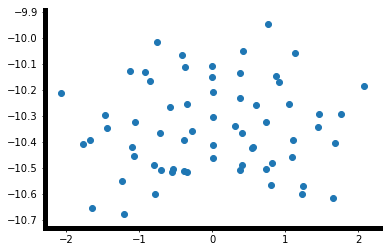

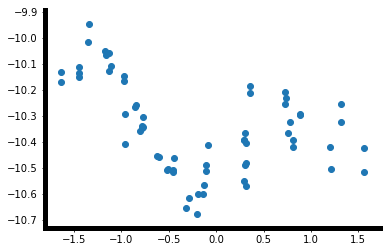

In [26]:
# Make topos, for each state, within and between datasets, for all features and bands
spatial_corr_trial = make_topos_dict([PBA_trial_results, rtPB_trial_results],
                                     label="Trial", eeg_dat_info=eeg_dat.info, pos=pos, save_fig=SAVE_FIGS)
spatial_corr_rest = make_topos_dict([PBA_rest_results, rtPB_rest_results],label="Rest",
                                    eeg_dat_info=eeg_dat.info, pos=pos, save_fig=SAVE_FIGS)
spatial_slope_corr_trial = make_topos_array([PBA_trial_slope_results, rtPB_trial_slope_results],
                                            label="Trial", eeg_dat_info=eeg_dat.info, pos=pos,
                                            feats=['Offsets', 'Slope'], save_fig=SAVE_FIGS)
spatial_slope_corr_rest = make_topos_array([PBA_rest_slope_results, rtPB_rest_slope_results], 
                                            label="Rest", eeg_dat_info=eeg_dat.info, pos=pos,                                             
                                            feats=['Offsets', 'Slope'], save_fig=SAVE_FIGS)

# Spatial Correlations Between Bands

NOTE: In Progess

In [ ]:

index = group_bands.keys()
d_corrm = pd.DataFrame(index=index, columns=index, dtype = float)
#Dataframe for correlaton matrix
for band in group_bands:
    data1 = group_bands[band][:,features[feature]]
    for band2 in group_bands:
        data2 = group_bands[band2][:,features[feature]]
        masked_arr1=mask_nan_array(data1)
        masked_arr2=mask_nan_array(data2)
        corr_val = pearsonr(data1, data2)[0]
        d_corrm.loc[band, band2] = corr_val



In [ ]:
plt.imshow(d_corrm)

# Analyses Across TIME

In [ ]:
PBA_across_corr_trial = run_dict_across_blocks('PBA', PBA_trial_results, pos_ch_cluster_index, True)
rtPB_across_corr_trial = run_dict_across_blocks('rtPB', rtPB_trial_results, pos_ch_cluster_index, True)

PBA_across_slope_corr_trial = run_array_across_blocks('PBA', PBA_trial_slope_results,
                                                      pos_ch_cluster_index, ['Off', 'Sl'], True)
rtPB_across_slope_corr_trial = run_array_across_blocks('rtPB', rtPB_trial_slope_results,
                                                       pos_ch_cluster_index, ['Off', 'Sl'], True)